# Steps
1. Generate a population with fake preference vectors
2. Make them into k groups using ``boosting sortition''
3. create reward models for the k groups
4. train some policy with the k groups

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [62]:
# sample age from a normal distribution with mean 50 and standard deviation 20
# age = np.random.normal(1, 1, 100)
# income = np.random.normal(0, 1, 100)

#uniform between 0 and 1
age = np.random.rand(100)
income = np.random.rand(100)



# age = np.random.randint(10, 100, 100)
# income = np.random.randint(10000, 100000, 100)

# create a list of tuples
people = list(zip(age, income))


# convert to a list of tuples
people = [tuple(x) for x in people]

print(people[0])

(0.2189346793569229, 0.991474266789678)


In [14]:
def fair_greedy_capture(population, metric, k, q):
    """
    :param population: List of individuals in the population.
    :param metric: A function that calculates the metric of interest between two individuals.
    :param k: Total number of representatives to select.
    :param q: A parameter influencing the fairness and diversity of the selection.
    
    :return: panel of selected representatives.
    """

    R = population.copy()
    delta = 0
    panel = set()
    n = len(population)
    # print(np.ceil(q * (n/k)))

    len_B = 0

    while len(R) >= np.ceil(q * (n/k)):
        # while there is a j in R such that 
        # print("len(R): ", len(R))
        for j in R:
            # find all members of R that are within distance delta of j
            B = set()
            for i in R:
                if metric(i, j) <= delta:
                    # print(i)
                    B.add(i)
            if len(B) > len_B or len_B < len(B):
                len_B = len(B)
                # print("len(B): ", len(B))
            if len(B) >= np.ceil(q * (n/k)):
                # randomly select np.ceil(q * (n/k)) members of B to add to set S
                S = set()
                # select np.ceil(q * (n/k)) members of B to add to set S
                lB = list(B)
                B_indices = list(range(len(lB)))
                while len(S) < np.ceil(q * (n/k)):
                    # randomly select a tuple from B
                    choice = np.random.choice(B_indices)
                    S.add(lB[choice])
                    B_indices.remove(choice)
                # pick q individuals from S to add to add to P_hat
                P_hat = set()
                #select  q individuals from S to add to P_hat
                lS = list(S)
                S_indices = list(range(len(lS)))
                while len(P_hat) < q:
                    choice = np.random.choice(S_indices)
                    P_hat.add(lS[choice])
                    S_indices.remove(choice)
                # add P_hat to the panel
                panel = panel.union(P_hat)
                #remove S from R
                for i in S:
                    R.remove(i)

        delta += 1

    if len(panel) < k:
        # print("len(panel) < k")
        PR = [k/n for _ in len(R)]

        leftovers = []
        for i in population:
            if i not in panel and i not in R:
                leftovers.append(i)
        P_leftovers = [(k-len(panel)-len(R)*(k/n))/(n-len(panel)-len(R)) for _ in len(leftovers)]

        # select k-len(panel) individuals
        pool = R + leftovers
        probabilities = PR + P_leftovers
        selected = np.random.choice(pool, k-len(panel), p=probabilities)
        panel = panel.union(selected)

    # print("delta: ", delta)
    return panel

In [15]:
def euclidean_distance(i, j):
    # calculate the euclidean distance between two individuals
    return np.sqrt((i[0] - j[0])**2 + (i[1] - j[1])**2)


# Example usage
population = people
k = 10
q = 1
selected_representatives = fair_greedy_capture(population, euclidean_distance, k, q)

In [16]:
print(len(selected_representatives))
print(selected_representatives)

10
{(36, 97505), (84, 33212), (95, 22064), (57, 26197), (28, 47357), (47, 72586), (87, 65240), (61, 15276), (54, 81346), (54, 51681)}


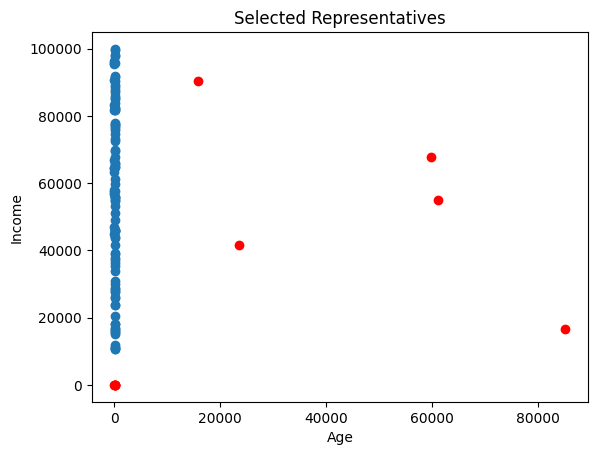

In [9]:
# plot the selected representatives
plt.scatter(age, income)
for i in selected_representatives:
    plt.scatter(i[0], i[1], color='red')

plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Selected Representatives')
plt.show()

The cost of an individual 𝑖 for a panel 𝑃 with parameter 𝑞 ∈ [𝑘], denoted by 𝑐𝑞 (𝑖, 𝑃; 𝑑) and called 𝑞-cost (or simply cost, when 𝑞 is implied from the context), is equal to the distance of 𝑖 from her 𝑞-th closest member in the panel

In [10]:
def q_cost(i, P, q, metric):
    """
    The distance between individual i and the q-th closest individual in P.

    :param i: An individual.
    :param P: A set of individuals.
    :param q:
    :param metric: A function that calculates the distance between two individuals.
    """
    distances = []
    for j in P:
        distances.append(metric(i, j))
    distances = np.array(distances)
    indices = np.argsort(distances)
    # print(distances)
    return distances[indices[q-1]]
    


def audit(selected_representatives, population, metric, k, q):
    """
    :param selected_representatives: List of selected representatives.
    :param population: List of individuals in the population.
    :param metric: A function that calculates the metric of interest between two individuals.
    :param k: Total number of representatives to select.
    :param q: A parameter influencing the fairness and diversity of the selection.
    
    :return: alpha
    """
    alphas = []
    #the q-cost for each individual in the population for the selected representatives
    c_q_P = []
    for i in population:
        c_q_P.append(q_cost(i, selected_representatives, q, metric))
    for j in population:
        P_hat_j = set()
        # find the q-1 closest individuals to j
        distances = []
        for i in population:
            distances.append(metric(i, j))
        distances = np.array(distances)
        indices = np.argsort(distances)
        for i in indices[:q]:
            # print(distances[i], i)
            P_hat_j.add(population[i])
        # print("Len",len(P_hat_j))
        #find distance to q-th closest individual
        c_q_P_hat = []
        for i in population:
            c_q_P_hat.append(q_cost(i, P_hat_j, q, metric))

        #make array of c_q_P / c_q_P_hat
        ratios = np.array(c_q_P) / np.array(c_q_P_hat)
        ratios = np.sort(ratios)
        idx = np.ceil(q*(len(population)/k))

        alpha_hat_j = ratios[int(idx)]
        alphas.append(alpha_hat_j)

    
    # argmax of alphas
    alpha_hat = np.argmax(alphas)

    return alpha_hat   

In [11]:
selected_representatives = fair_greedy_capture(population, euclidean_distance, k, q)
audit(selected_representatives, population, euclidean_distance, k, q)

KeyboardInterrupt: 

In [ ]:
print((5+np.sqrt(41))/2)

5.701562118716424


# Chen et al. 2019

M is feasible cluster centers

In [77]:
def B(x, delta, population, metric):
    """
    Find all members of the population that are within distance delta of x.

    :param x: An individual.
    :param delta: A radius.
    :param population: List of individuals in the population.
    :param metric: A function that calculates the metric of interest between two individuals.
    """
    B = []
    for i in population:
        if metric(x, i) <= delta:
            B.append(i)
    return B

def M(X, N):
    """
    Find the candidate individuals to add to the panel. i.e. the individuals in N that are not in X.

    :param X: The current panel.
    :param N: The remaining population.
    """
    candidates = []
    for i in N:
        if i not in X:
            candidates.append(i)
    return candidates

def greedy_capture(population, metric, k):
    delta = 0 # ball radius
    X = set() # panel

    N = population.copy()

    print("N: ", len(N))

    n = len(N)

    EM = population.copy()
    
    while len(N) > 0:
        # Smoothly increase delta - implement this according to your specific problem
        delta += 0.0001
        
        for x in X: # continued capture
            B_x = B(x, delta, population, metric)
            # if len(B_x) >= 1:
            if len(set(B_x).intersection(set(N))) >= 1:
                for y in B_x:
                    #remove y from N
                    if y in N:
                        N.remove(y)
                # print("N: ", len(N))

        for i in M(X, N): # ball opening
           B_i = B(i, delta, population, metric)
           if len(set(B_i).intersection(set(N))) >= np.ceil(n/k):
               print("Center Opened: ", i)
               X.add(i)
               for j in B_i:
                   if j in N:
                       N.remove(j)

    return X

In [78]:
# Example usage
population = people
k = 20
selected_representatives = greedy_capture(population, euclidean_distance, k)

print(len(selected_representatives))
print(selected_representatives)

N:  100
Center Opened:  (0.7246989345337049, 0.04779243138836353)
Center Opened:  (0.2060008429711212, 0.068113861556239)
Center Opened:  (0.6039975099473555, 0.5253976195680742)
Center Opened:  (0.44670997346563257, 0.3187760625001679)
Center Opened:  (0.06060528065955639, 0.5053298462455155)
Center Opened:  (0.8034314472608152, 0.27721004526940984)
Center Opened:  (0.9860289579336357, 0.20498438074986736)
Center Opened:  (0.8479226169171713, 0.5540770328250824)
Center Opened:  (0.35957719980017333, 0.8507338186280655)
Center Opened:  (0.46554947966525884, 0.5019680126355902)
Center Opened:  (0.653877284554929, 0.6971480065193314)
Center Opened:  (0.2960518897796588, 0.5993803555345631)
Center Opened:  (0.42337909096791737, 0.12320696474809456)
Center Opened:  (0.893678753978549, 0.8276735900777352)
Center Opened:  (0.10164226503562135, 0.9449694603032232)
15
{(0.2960518897796588, 0.5993803555345631), (0.6039975099473555, 0.5253976195680742), (0.2060008429711212, 0.068113861556239), (

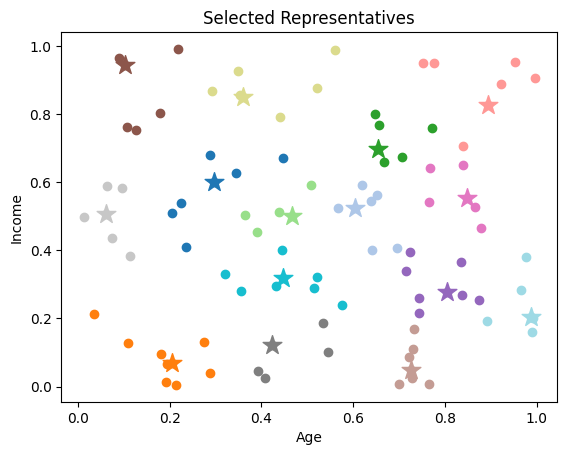

In [81]:
colors = plt.cm.tab20(np.linspace(0, 1, len(selected_representatives)))


for i in population:
    distances = []
    for j in selected_representatives:
        distances.append(euclidean_distance(i, j))
    closest_representative = list(selected_representatives)[np.argmin(distances)]
    plt.scatter(i[0], i[1], color=colors[list(selected_representatives).index(closest_representative)])

# plot the selected representatives as stars of the same color and make it bigger
for i in selected_representatives:
    plt.scatter(i[0], i[1], color=colors[list(selected_representatives).index(i)], marker='*', s=200)

plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Selected Representatives')
plt.show()